# Facial Emotion Recogination

reference : https://www.kaggle.com/aroraumang/facial-emotion-recogination-82-accuracy

Importing libraries

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from keras.utils import plot_model

Importing Dataset

In [2]:
train_dir = 'fer2013/train/'
test_dir = 'fer2013/test/'

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       angry  disgust  fear  happy  neutral   sad  surprise
train   3995      436  4097   7215     4965  4830      3171
      angry  disgust  fear  happy  neutral   sad  surprise
test    957      111  1024   1774     1233  1247       831


Plot of number of images in training set

<AxesSubplot:>

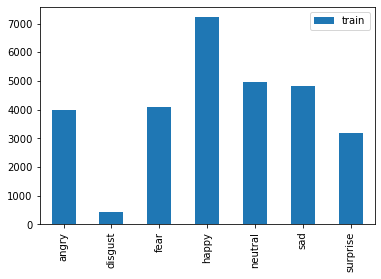

In [3]:
train_count.transpose().plot(kind='bar')

Plot of number of images in test set

<AxesSubplot:>

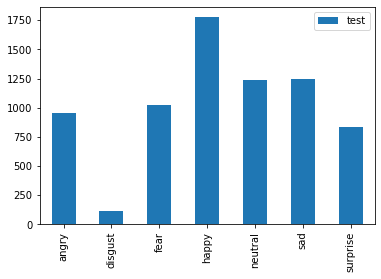

In [4]:
test_count.transpose().plot(kind='bar')

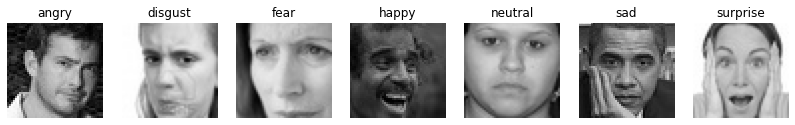

In [5]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

Creating Training and Test sets

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7177 images belonging to 7 classes.


In [7]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

Defining Model

In [8]:
def get_model(input_size, classes=7):
     #Initialising the CNN
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))

    #Compliling the model
    model.compile(optimizer=Adam(lr=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [9]:
fernet = get_model((row,col,1), classes)
fernet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 256)       2

In [10]:
#!pip install pydot
#!pip install graphviz
#!pip install pydotplus
#!pip install django-extensions
#!pip install pyparsing

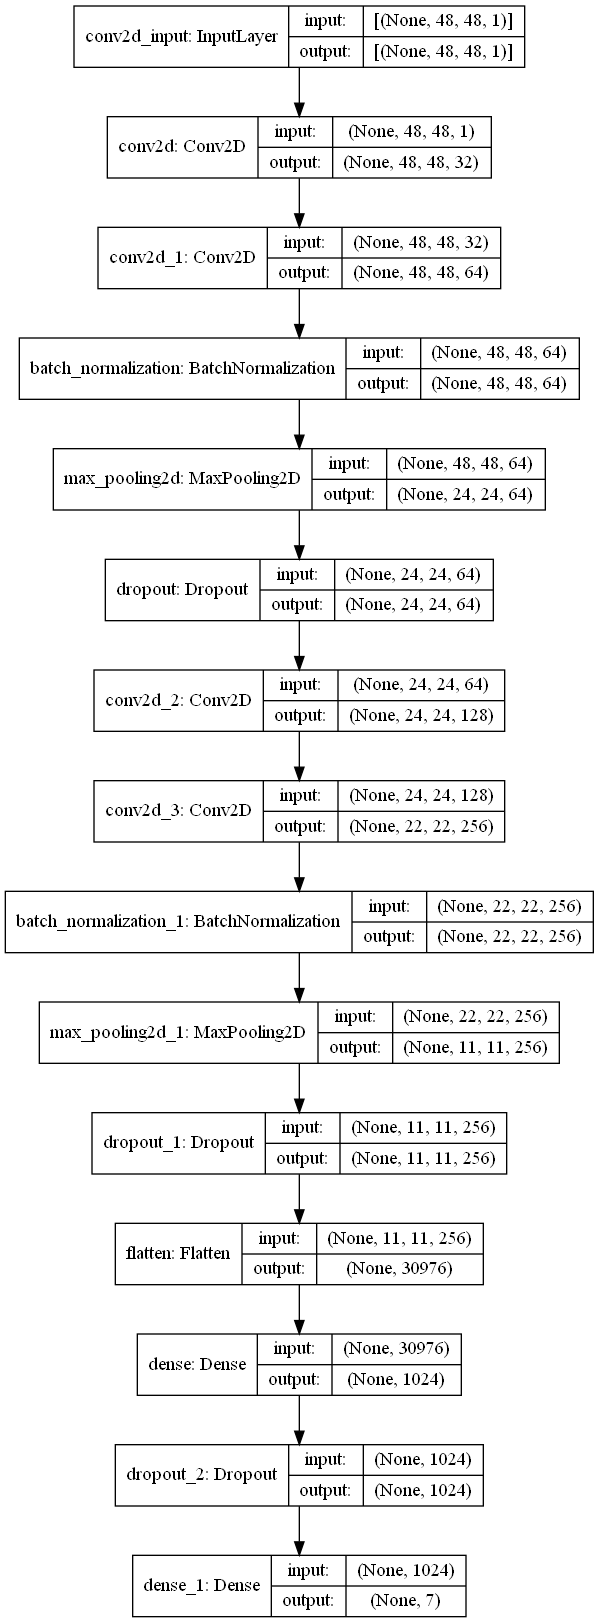

In [11]:
plot_model(fernet, to_file='fernet.png', show_shapes=True, show_layer_names=True)

Callbacks Function

In [12]:
chk_path = 'models_1_1.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

Training Model

In [13]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = fernet.fit(x=training_set,
                 validation_data=test_set,
                 epochs=60,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/60
448/448 [==============================] - 1324s 3s/step - loss: 4.8976 - accuracy: 0.2523 - val_loss: 6.9472 - val_accuracy: 0.1985

Epoch 00001: val_loss improved from inf to 6.94716, saving model to model_1_1.h5
Epoch 2/60
448/448 [==============================] - 1349s 3s/step - loss: 3.6481 - accuracy: 0.3321 - val_loss: 3.0968 - val_accuracy: 0.4163

Epoch 00002: val_loss improved from 6.94716 to 3.09683, saving model to model_1_1.h5
Epoch 3/60
448/448 [==============================] - 1451s 3s/step - loss: 3.1022 - accuracy: 0.3746 - val_loss: 2.6773 - val_accuracy: 0.4297

Epoch 00003: val_loss improved from 3.09683 to 2.67725, saving model to model_1_1.h5
Epoch 4/60
448/448 [==============================] - 1467s 3s/step - loss: 2.6658 - accuracy: 0.3986 - val_loss: 2.3089 - val_accuracy: 0.4628

Epoch 00004: val_loss improved from 2.67725 to 2.30894, saving model to model_1_1.h5
Epoch 5/60
448/448 [==============================] - 1220s 3s/step - loss: 2.3231 -

448/448 [==============================] - 1190s 3s/step - loss: 0.6690 - accuracy: 0.7901 - val_loss: 1.1116 - val_accuracy: 0.6629

Epoch 00038: val_loss did not improve from 1.08233
Epoch 39/60
448/448 [==============================] - 1197s 3s/step - loss: 0.6512 - accuracy: 0.7967 - val_loss: 1.1138 - val_accuracy: 0.6639

Epoch 00039: val_loss did not improve from 1.08233
Epoch 40/60
448/448 [==============================] - 1112s 2s/step - loss: 0.6572 - accuracy: 0.7921 - val_loss: 1.1132 - val_accuracy: 0.6657

Epoch 00040: val_loss did not improve from 1.08233
Epoch 41/60
448/448 [==============================] - 1148s 3s/step - loss: 0.6554 - accuracy: 0.7963 - val_loss: 1.1126 - val_accuracy: 0.6652

Epoch 00041: val_loss did not improve from 1.08233
Epoch 42/60
448/448 [==============================] - 1115s 2s/step - loss: 0.6499 - accuracy: 0.7973 - val_loss: 1.1125 - val_accuracy: 0.6646

Epoch 00042: val_loss did not improve from 1.08233
Epoch 43/60
448/448 [======

Loss and Accuracy plot

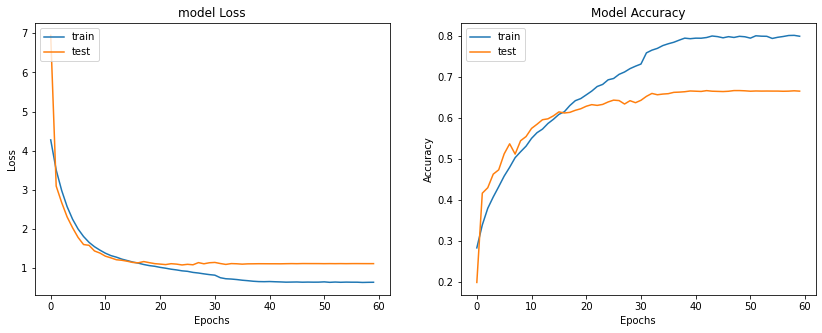

In [14]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Model Evaluation

In [15]:
train_loss, train_accu = fernet.evaluate(training_set)
test_loss, test_accu = fernet.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 51s 453ms/step - loss: 1.1163 - accuracy: 0.6653
final train accuracy = 87.08 , validation accuracy = 66.53


In [16]:
fernet.save_weights('fernet_bestweight.h5')

In [17]:
fernet.save('model_best_1_1.h5')

Confusion Matrix and Classification on training set

In [19]:
per = np.random.permutation(training_set.n)
training_set.index_array = per
classes = training_set.classes[per]

Confusion Matrix
[[3293    5  150   73  217  225   32]
 [  35  366   10    3    6   11    5]
 [ 190    4 3159   75  217  282  170]
 [  34    0   39 6924  122   35   61]
 [  93    1   73  191 4341  235   31]
 [ 187    2  175   62  363 4021   20]
 [  35    2   92   79   54   27 2882]]
Classification Report
              precision    recall  f1-score   support

       angry       0.85      0.82      0.84      3995
     disgust       0.96      0.84      0.90       436
        fear       0.85      0.77      0.81      4097
       happy       0.93      0.96      0.95      7215
     neutral       0.82      0.87      0.84      4965
         sad       0.83      0.83      0.83      4830
    surprise       0.90      0.91      0.90      3171

    accuracy                           0.87     28709
   macro avg       0.88      0.86      0.87     28709
weighted avg       0.87      0.87      0.87     28709



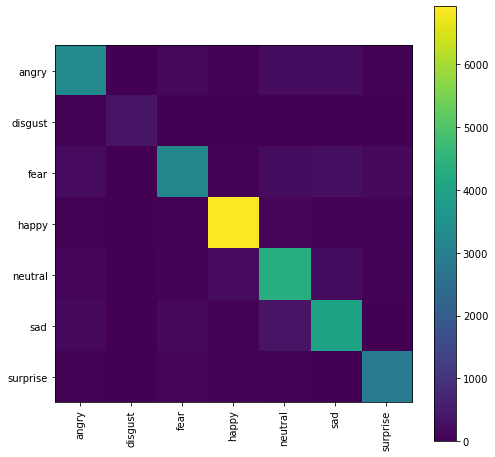

In [20]:
y_pred = fernet.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

Confusion Matrix and Classification on test set

In [21]:
per = np.random.permutation(test_set.n)
test_set.index_array = per
classes = test_set.classes[per]

Confusion Matrix
[[136   8 108 247 190 161 107]
 [ 12   1  12  29  22  24  11]
 [155   8 106 249 216 179 111]
 [251  17 224 444 332 294 212]
 [188  11 139 323 237 197 138]
 [184   9 129 312 245 214 154]
 [109  12 100 201 162 153  94]]
Classification Report
              precision    recall  f1-score   support

       angry       0.13      0.14      0.14       957
     disgust       0.02      0.01      0.01       111
        fear       0.13      0.10      0.12      1024
       happy       0.25      0.25      0.25      1774
     neutral       0.17      0.19      0.18      1233
         sad       0.18      0.17      0.17      1247
    surprise       0.11      0.11      0.11       831

    accuracy                           0.17      7177
   macro avg       0.14      0.14      0.14      7177
weighted avg       0.17      0.17      0.17      7177



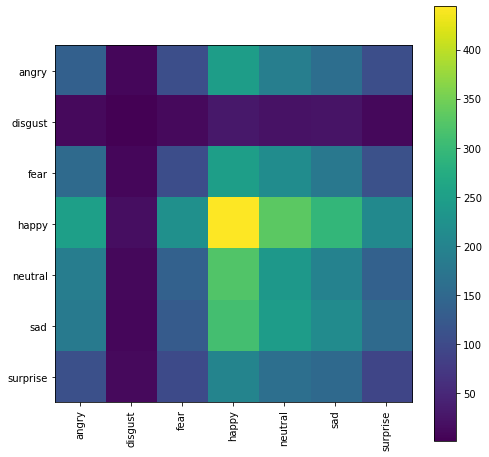

In [23]:
y_pred = fernet.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

#from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

# 단일 사진 결과 확인

In [25]:
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import cv2
import numpy as np
import sys
import time
#from google.colab.patches import cv2_imshow
 
# parameters for loading data and images
detection_model_path = 'haarcascade_files/haarcascade_frontalface_default.xml'
emotion_model_path = 'model_best_1_1.h5'
#emotion_model_path = 'fernet_bestweight.h5'
img_path =  "angry.jpg" # sys.argv[1]
 
# hyper-parameters for bounding boxes shape
# loading models
face_detection = cv2.CascadeClassifier(detection_model_path)
emotion_classifier = load_model(emotion_model_path, compile=False)
EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
 
# reading the frame
orig_frame = cv2.imread(img_path)
#print(img_path)
#print(orig_frame)
frame = cv2.imread(img_path,0)
#print(frame)
faces = face_detection.detectMultiScale(frame,scaleFactor=1.1,minNeighbors=5,minSize=(30,30),flags=cv2.CASCADE_SCALE_IMAGE)
 
if len(faces) > 0:
    print(faces)
    faces = sorted(faces, reverse=True,key=lambda x: (x[2] - x[0]) * (x[3] - x[1]))[0]
    (fX, fY, fW, fH) = faces
    roi = frame[fY:fY + fH, fX:fX + fW]
    roi = cv2.resize(roi, (48, 48))
    roi = roi.astype("float") / 255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi, axis=0)
    preds = emotion_classifier.predict(roi)[0]
    emotion_probability = np.max(preds)
    label = EMOTIONS[preds.argmax()]
    cv2.putText(orig_frame, label, (fX, fY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
    cv2.rectangle(orig_frame, (fX, fY), (fX + fW, fY + fH),(0, 0, 255), 2)
 
cv2.imshow('test_face', orig_frame)
#cv2_imshow(orig_frame)
cv2.imwrite('test_output/'+img_path.split('/')[-1],orig_frame)
if (cv2.waitKey(0) and 0xFF == ord('q')):
    sys.exit("Thanks")
cv2.destroyAllWindows()

[[182 146 471 471]]


In [26]:
roi.shape

(1, 48, 48, 1)

# 실시간 영상을 통한 결과 확인

In [27]:
from statistics import mode

import cv2
from keras.models import load_model
import numpy as np

from utils.datasets import get_labels
from utils.inference import detect_faces
from utils.inference import draw_text
from utils.inference import draw_bounding_box
from utils.inference import apply_offsets
from utils.inference import load_detection_model
from utils.preprocessor import preprocess_input

# parameters for loading data and images
detection_model_path = 'haarcascade_files/haarcascade_frontalface_default.xml'
emotion_model_path = 'model_best_1_1.h5'
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# hyper-parameters for bounding boxes shape
frame_window = 10
emotion_offsets = (20, 40)

# loading models
face_detection = load_detection_model(detection_model_path)
emotion_classifier = load_model(emotion_model_path, compile=False)

# getting input model shapes for inference
emotion_target_size = emotion_classifier.input_shape[1:3]

# starting lists for calculating modes
emotion_window = []

In [28]:
face_detection

<CascadeClassifier 000001D84CF485D0>

In [29]:
emotion_labels

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [30]:
from keras.preprocessing.image import img_to_array

# starting video streaming
cv2.namedWindow('window_frame')
video_capture = cv2.VideoCapture(0)
while True:
    bgr_image = video_capture.read()[1]
    gray_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2GRAY)
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    faces = detect_faces(face_detection, gray_image)
    
    for face_coordinates in faces:

        x1, x2, y1, y2 = apply_offsets(face_coordinates, emotion_offsets)
        gray_face = gray_image[y1:y2, x1:x2]
        try:
            gray_face = cv2.resize(gray_face, (emotion_target_size))
        except:
            continue

        gray_face = preprocess_input(gray_face, True)
        gray_face = np.expand_dims(gray_face, 0)
        gray_face = np.expand_dims(gray_face, -1)
        emotion_prediction = emotion_classifier.predict(gray_face)
        emotion_probability = np.max(emotion_prediction)
        emotion_label_arg = np.argmax(emotion_prediction)
        emotion_text = emotion_labels[emotion_label_arg]
        emotion_window.append(emotion_text)

        if len(emotion_window) > frame_window:
            emotion_window.pop(0)
        try:
            emotion_mode = mode(emotion_window)
        except:
            continue

        if emotion_text == 'angry':
            color = emotion_probability * np.asarray((255, 0, 0))
        elif emotion_text == 'happy':
            color = emotion_probability * np.asarray((0, 0, 255))
        elif emotion_text == 'neutral':
            color = emotion_probability * np.asarray((255, 255, 0))
        elif emotion_text == 'sad':
            color = emotion_probability * np.asarray((0, 255, 255))
        else:
            color = emotion_probability * np.asarray((0, 255, 0))

        color = color.astype(int)
        color = color.tolist()

        draw_bounding_box(face_coordinates, rgb_image, color)
        draw_text(face_coordinates, rgb_image, emotion_mode,
                  color, 0, -45, 1, 1)
        draw_text(face_coordinates, rgb_image, str(emotion_labels[0])+' : '+str(round(emotion_prediction[0][0],2)),
                  [0, 99, 99], 250, 10, 1, 1)
        draw_text(face_coordinates, rgb_image, str(emotion_labels[1])+' : '+str(round(emotion_prediction[0][3],2)),
                  [99, 0, 99], 250, 60, 1, 1)
        draw_text(face_coordinates, rgb_image, str(emotion_labels[2])+' : '+str(round(emotion_prediction[0][4],2)),
                  [0, 99, 0], 250, 110, 1, 1)
        draw_text(face_coordinates, rgb_image, str(emotion_labels[3])+' : '+str(round(emotion_prediction[0][6],2)),
                  [0, 0, 0], 250, 160, 1, 1)
        
        
        
    bgr_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2BGR)
    cv2.imshow('window_frame', bgr_image)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video_capture.release()
cv2.destroyAllWindows()

In [4]:
emotion_prediction

array([[0.08067222, 0.00115075, 0.12079898, 0.03534332, 0.12717518,
        0.62350965, 0.01135   ]], dtype=float32)